# Model deployment of Fine-Tuned Llama 3.1 8B in Amazon SageMaker

---

In this demo notebook, we demonstrate how to deploy the fine-tuned model from the notebook [01_llama-3.1-8b-qlora-sft.ipynb](./01_llama-3.1-8b-qlora-sft.ipynb) in an Amazon SageMaker real-time endpoint.

---

JupyterLab Instance Type: ml.t3.medium

Install the required libriaries, including the Hugging Face libraries, and restart the kernel.

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -q -U boto3
%pip install -q -U botocore
%pip install -q -U Levenshtein
%pip install -q -U scikit-learn==1.5.1
%pip install -q -U seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



## Setup Configuration file path

We are setting the directory in which the config.yaml file resides so that remote decorator can make use of the settings through [SageMaker Defaults](https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk).

This notebook is using the Hugging Face container for the `us-east-1` region. Make sure you are using the right image for your AWS region, otherwise edit [config.yaml](./config.yaml). Container Images are available [here](https://github.com/aws/deep-learning-containers/blob/master/available_images.md)


In [3]:
import os

# Set path to config file
os.environ["SAGEMAKER_USER_CONFIG_OVERRIDE"] = os.getcwd()

## Deploy the Fine-Tuned model

In [4]:
import sagemaker

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Fetched defaults config from location: /home/sagemaker-user/personalgithubrepo/customize-llm-automotive-aws


In [5]:
sagemaker_session = sagemaker.Session()

In [6]:
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"

bucket_name = sagemaker_session.default_bucket()
job_prefix = f"train-{model_id.split('/')[-1].replace('.', '-')}-auto"

In [7]:
def get_last_job_name(job_name_prefix):
    import boto3
    sagemaker_client = boto3.client('sagemaker')

    search_response = sagemaker_client.search(
        Resource='TrainingJob',
        SearchExpression={
            'Filters': [
                {
                    'Name': 'TrainingJobName',
                    'Operator': 'Contains',
                    'Value': job_name_prefix
                },
                {
                    'Name': 'TrainingJobStatus',
                    'Operator': 'Equals',
                    'Value': "Completed"
                }
            ]
        },
        SortBy='CreationTime',
        SortOrder='Descending',
        MaxResults=1)

    return search_response['Results'][0]['TrainingJob']['TrainingJobName']

In [8]:
job_name = get_last_job_name(job_prefix)

job_name

'train-Meta-Llama-3-1-8B-Instruct-auto-2025-02-03-11-42-49-388'

#### Inference configurations

In [9]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.huggingface import HuggingFaceModel, get_huggingface_llm_image_uri

In [15]:
instance_count = 1
instance_type = "ml.g5.4xlarge"
number_of_gpu = 1
health_check_timeout = 700

In [32]:
import json

model = HuggingFaceModel(
    image_uri='763104351884.dkr.ecr.us-west-2.amazonaws.com/huggingface-pytorch-tgi-inference:2.4.0-tgi2.3.1-gpu-py311-cu124-ubuntu22.04-v2.0', #image_uri with py311
    model_data=f"s3://{bucket_name}/{job_name}/{job_name}/output/model.tar.gz",
    role=get_execution_role(),
    env={
        'HF_MODEL_ID': "/opt/ml/model", # path to where sagemaker stores the model
        'SM_NUM_GPUS': json.dumps(number_of_gpu), # Number of GPU used per replica
        'HF_MODEL_QUANTIZE': 'bitsandbytes',
        'MAX_INPUT_LENGTH': '4096',
        'MAX_TOTAL_TOKENS': '8192'
    }
)

sagemaker.config INFO - Applied value from config key = SageMaker.Model.EnableNetworkIsolation


In [33]:
predictor = model.deploy(
    initial_instance_count=instance_count,
    instance_type=instance_type,
    container_startup_health_check_timeout=health_check_timeout,
    model_data_download_timeout=3600
)

----------!

## Model Evaluation - Fine-tuned model vs. Base model

We are going to evaluate the fine-tuned model and the base model on two metrics:
* BLEU Score
* Accuracy score with Levenshtein distance

BLEU (bilingual evaluation understudy) is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another.


Normalized Levenshtein distance is an algorithm for evaluating accuracy degree of how close the calculated or measured values are to the actual value.

### Define Model predictor

In [34]:
from sagemaker.huggingface.model import HuggingFacePredictor

In [35]:
endpoint_name = "<ENDPOINT_NAME>" #Required if you want to create a predictor without running the previous code

In [36]:
if 'predictor' not in locals() and 'predictor' not in globals():
    print("Create predictor")
    predictor = HuggingFacePredictor(
        endpoint_name=endpoint_name
    )

### Define Amazon Bedrock client

In [37]:
import boto3

In [38]:
bedrock_client = boto3.client('bedrock-runtime')

In [39]:
bedrock_model_id = "meta.llama3-8b-instruct-v1:0"

### Create an evaluation dataset

In [40]:
import pandas as pd

df = pd.read_csv("./sample_dataset.csv")

In [41]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.1, random_state=42)
train, valid = train_test_split(train, test_size=10, random_state=42)

print("Number of validation elements: ", len(valid))

Number of validation elements:  10


### Answer generation

In [52]:
#Let us first do a small test...
row = valid.iloc[0]
row['DESC_DEFECT']

'PACCAR Incorporated (PACCAR) is recalling certain model year 2011-2016 Kenworth T270, T370, T440, T470, C500, C540, C550, T660, T800, W900, and 963 trucks manufactured November 1, 2010, to April 6, 2015.  In the affected trucks, water may leak into the wiper motor.'

In [72]:
def build_defect_request_body(row, top_p=0.9, temperature=0.2, max_new_tokens=512):
    prompt = f"""<|begin_of_text|><|start_header_id|>user<|end_header_id|>These are the information related to the defect:\nManufacturer: {row['MFGNAME']}\nComponent: {row['COMPNAME']}\nDescription of the defect: {row['DESC_DEFECT']}\n\n\nWhat are the consequences of defect?<|eot_id|><|start_header_id|>assistant<|end_header_id|>"""

    return {
        'inputs': prompt,
        'parameters': {
            "top_p": top_p,
            "temperature": temperature,
            "max_new_tokens": max_new_tokens,
            "return_full_text": False,
            "stop": [
                '<|eot_id|>',
                '<|end_of_text|>'
            ]
        }
    }

In [75]:
predictor.predict(build_defect_request_body(row))

[{'generated_text': 'malfunctioning exterior marker lights can increase the risk of a crash.'}]

In [76]:
import json
import time

evaluation_set = []

for index, row in valid.iterrows():
    print("Example ", index)

    ## Generate response with the fine-tuned model
    body = build_defect_request_body(row)

    start_time = time.time()

    response = predictor.predict(body)

    end_time = time.time()

    print(f"Generated response with fine-tuned model: {end_time - start_time:.6f} seconds")

    response_fine_tuned = response[0]['generated_text'].strip()

    print(response_fine_tuned)

    ## Generate response with the base model

    prompt = f"""
        These are the information related to the defect:
        Manufacturer: {row['MFGNAME']}
        Component: {row['COMPNAME']}
        Description of a defect:
        {row['DESC_DEFECT']}
    """

    messages = [
        {
            "role": "user",
            "content": [{"text": prompt},
                        {"text": "What are the consequences?"}]
        }
    ]

    start_time = time.time()

    response = bedrock_client.converse(
        modelId=bedrock_model_id,
        messages=messages,
        inferenceConfig={
            "temperature": 0.2,
            "topP": 0.9,
            "maxTokens": 512
        }
    )

    end_time = time.time()

    print(f"Generated response with base model: {end_time - start_time:.6f} seconds")

    response_base = response['output']['message']["content"][0]["text"]
    print(response_base)

    evaluation_set.append({
        "index": index,
        "target_answer": row["CONEQUENCE_DEFECT"],
        "fine_tuned_answer": response_fine_tuned,
        "base_answer": response_base
    })

    print("******************")

with open("llama_32_1b_evaluation_dataset.json", "w") as f:
    json.dump(evaluation_set, f, indent=4)

Example  2733
Generated response with fine-tuned model: 2.240939 seconds
water leaking into the wiper motor may cause the wiper motor to fail, reducing the driver's visibility and increasing the risk of a crash.
Generated response with base model: 1.475031 seconds


Based on the information provided, the consequences of the defect are:

* Water may leak into the wiper motor.

This could potentially lead to:

* Malfunctioning or failure of the wiper motor
* Reduced visibility while driving, which could increase the risk of accidents
* Potential damage to other electrical components in the vehicle
* Increased risk of corrosion or rust in the wiper motor and surrounding areas

It is recommended that the affected vehicles be inspected and repaired by a qualified technician to prevent these potential consequences.
******************
Example  3382
Generated response with fine-tuned model: 2.103293 seconds
In the event of a fire, the seat may not provide the necessary protection to the occupa

### BLEU Score evaluation

In [62]:
import nltk
import re

def clean_array(string):
    filtered_words = []
    
    for element in string:
        cleaned_word = re.sub(r'[^a-zA-Z]', '', element)
        if cleaned_word:
            filtered_words.append(cleaned_word)
    
    return filtered_words

def calculate_score(index, reference, hp_1, hp_2):
    reference_split = clean_array(reference.split(" "))
    
    hp_1_split = clean_array(hp_1.split(" "))
    hp_2_split = clean_array(hp_2.split(" "))
    
    BLEUscore_hp_1 = nltk.translate.bleu_score.sentence_bleu([reference_split], hp_1_split)
    BLEUscore_hp_2 = nltk.translate.bleu_score.sentence_bleu([reference_split], hp_2_split)
    print("Example ", index)
    print("Fine-tuned score: ", BLEUscore_hp_1)
    print("Base score: ", BLEUscore_hp_2)

    print("******************")

    return BLEUscore_hp_1, BLEUscore_hp_2

In [63]:
import json

with open('llama_32_1b_evaluation_dataset.json', 'r') as file:
    data = json.load(file)

file.close()

data = []

for el in evaluation_set:
    BLEUscore_fine_tuned, BLEUscore_base = calculate_score(
        el["index"],
        el["target_answer"],
        el["fine_tuned_answer"],
        el["base_answer"])
    
    data.append([el["index"], BLEUscore_fine_tuned, BLEUscore_base])

df = pd.DataFrame(data, columns=["index", "Fine-tuned score", "Base score"])

df["Fine-tuned score"] = df["Fine-tuned score"].astype(float)
df["Base score"] = df["Base score"].astype(float)

df.to_csv("./llama_32_1b_bleu_scores.csv", index=False)

Example  2733
Fine-tuned score:  0.19870007155050107
Base score:  4.596864051685539e-155
******************
Example  3382
Fine-tuned score:  1.8159331923129766e-78
Base score:  0.06485387090109423
******************
Example  1198
Fine-tuned score:  0.19895913918781657
Base score:  1.1441414120472538e-231
******************
Example  2942
Fine-tuned score:  0.7498810286408993
Base score:  2.827440655952787e-155
******************
Example  5151
Fine-tuned score:  5.502673892122423e-155
Base score:  0
******************
Example  2101
Fine-tuned score:  0.5189054572200645
Base score:  4.028401540644523e-155
******************
Example  5178
Fine-tuned score:  0.7245511487202049
Base score:  0.05520929029092705
******************
Example  1595
Fine-tuned score:  0.32128996628565337
Base score:  1.4486065219141897e-78
******************
Example  2313
Fine-tuned score:  0.948543837069451
Base score:  1.1939947320346412e-78
******************
Example  557
Fine-tuned score:  0.8931539818068694
Ba

/opt/conda/lib/python3.11/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.11/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.11/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

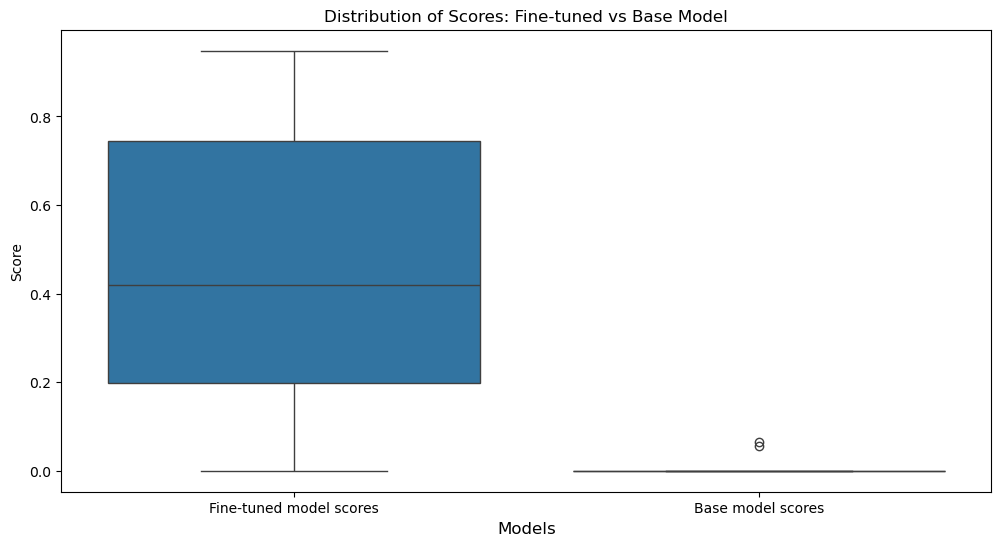

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv("llama_32_1b_bleu_scores.csv")

data1 = df['Fine-tuned score']
data2 = df['Base score']

combined_data = pd.DataFrame({
    'Fine-tuned model scores': data1,
    'Base model scores': data2
})

plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_data)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Score')
plt.title('Distribution of Scores: Fine-tuned vs Base Model')

plt.savefig('./images/llama_32_1b_bleu_scores.png')

plt.show()

#### BLEU Score Table

##### Example 1

Training Arguments:
* `epochs`: 1
* `per_device_train_batch_size`: 2
* `per_device_test_batch_size`: 2
* `gradient_accumulation_steps`: 2
* `gradient_checkpointing`: True

These results are obtained by fine-tuning on 6000 rows in total, where 3000 rows of the dataset were duplicated for having both therminology on the `CONEQUENCE_DEFECT` and `CORRECTIVE_ACTION`.

Total time for fine-tuning:
* `ml.g5.12xlarge`: ~42 minutes on 4 GPUs

Evaluation is performed on 10 rows extracted from the original dataset and not contained in the dataset used for the fine-tuning.

BLEU score is performed with the fine-tuned model hosted on Amazon SageMaker, with an `ml.g5.4xlarge`, and the base model in Amazon Bedrock.

Base model: `LLama-3.1 8B Instruct`

![BLEU Scores Table](./images/llama_32_1b_bleu_scores_table.png)

##### BLEU Scores graph

![BLEU Scores Table](./images/llama_32_1b_bleu_scores.png)

By comparing the scores in the "Fine-tuned Score" and "Base Score" columns, we can assess the performance improvement (or degradation) achieved by fine-tuning the model on the specific task or domain.

The analysis suggest that in most cases, the fine-tuned model seems to be outperforming the base model. The fine-tuned model appears to be more consistent in its performance.

Possible improvements:
* Examples repetition: Provide similar examples for improving further improving the vocabulary of the fine-tuned model
* Increse the number of epochs

***

Base model: `LLama-3 70B Instruct`

![BLEU Scores Table](./images/llama_32_1b_bleu_scores_table_70.png)

##### BLEU Scores graph

![BLEU Scores Table](./images/llama_32_1b_bleu_scores_70.png)

By comparing the scores in the "Fine-tuned Score" and "Base Score" columns, we can assess the performance improvement (or degradation) achieved by fine-tuning the model on the specific task or domain.

The analysis suggest that in most cases, the fine-tuned model seems to be outperforming the base model. The fine-tuned model appears to be more consistent in its performance.

Possible improvements:
* Examples repetition: Provide similar examples for improving further improving the vocabulary of the fine-tuned model
* Increse the number of epochs

***

### Accuracy evaluation

In [65]:
import Levenshtein

def levenshtein_similarity(str1, str2):
    distance = Levenshtein.distance(str1, str2)
    max_len = max(len(str1), len(str2))
    normalized_distance = 1 - (distance / max_len) if max_len > 0 else 1
    return normalized_distance

In [68]:
import json

with open('llama_32_1b_evaluation_dataset.json', 'r') as file:
    data = json.load(file)

file.close()

data = [] 

for el in evaluation_set:
    print("Example ", el["index"])
    score_fine_tuned = levenshtein_similarity(el["fine_tuned_answer"], el["target_answer"])
    print("Fine-tune score: ", score_fine_tuned)
    score_base = levenshtein_similarity(el["base_answer"], el["target_answer"])
    print("Base score: ", score_base)
    print("******************")

    data.append([el["index"], score_fine_tuned, score_base])

df = pd.DataFrame(data, columns=["index", "Fine-tuned score", "Base score"])

df["Fine-tuned score"] = df["Fine-tuned score"].astype(float)
df["Base score"] = df["Base score"].astype(float)

df.to_csv("./llama_32_1b_levenshtein_scores.csv", index=False)

Example  2733
Fine-tune score:  0.375886524822695
Base score:  0.26454033771106944
******************
Example  3382
Fine-tune score:  0.4086021505376344
Base score:  0.24761904761904763
******************
Example  1198
Fine-tune score:  0.4506172839506173
Base score:  0.261744966442953
******************
Example  2942
Fine-tune score:  0.8654970760233918
Base score:  0.18100890207715137
******************
Example  5151
Fine-tune score:  0.2628205128205128
Base score:  0.028328611898016942
******************
Example  2101
Fine-tune score:  0.7076271186440678
Base score:  0.29032258064516125
******************
Example  5178
Fine-tune score:  0.8571428571428572
Base score:  0.16728624535315983
******************
Example  1595
Fine-tune score:  0.49090909090909096
Base score:  0.214123006833713
******************
Example  2313
Fine-tune score:  0.9851851851851852
Base score:  0.21908893709327548
******************
Example  557
Fine-tune score:  0.9444444444444444
Base score:  0.12062256809

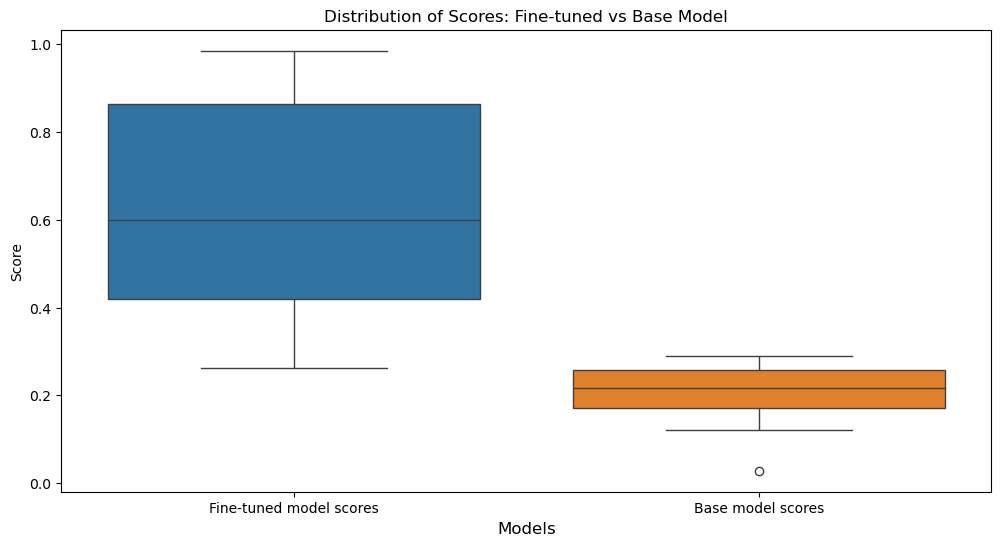

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv("llama_32_1b_levenshtein_scores.csv")

data1 = df['Fine-tuned score']
data2 = df['Base score']

combined_data = pd.DataFrame({
    'Fine-tuned model scores': data1,
    'Base model scores': data2
})

plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_data)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Score')
plt.title('Distribution of Scores: Fine-tuned vs Base Model')

plt.savefig('./images/llama_32_1b_levenshtein_scores.png')

plt.show()

#### Normalized Levenshtein Score Table

#### Example 1

Training Arguments:
* `epochs`: 1
* `per_device_train_batch_size`: 2
* `per_device_test_batch_size`: 1
* `gradient_accumulation_steps`: 2
* `gradient_checkpointing`: True

These results are obtained by fine-tuning on 6000 rows in total, where 3000 rows of the dataset were duplicated for having both therminology on the `CONEQUENCE_DEFECT` and `CORRECTIVE_ACTION`.

Total time for fine-tuning:
* `ml.g5.12xlarge`: ~39 minutes on 4 GPUs

Evaluation is performed on 10 rows extracted from the original dataset and not contained in the dataset used for the fine-tuning.

Levenshtein score is performed with the fine-tuned model hosted on Amazon SageMaker, with an `ml.g5.4xlarge`, and the base model in Amazon Bedrock.

Base model: `LLama-3.1 8B Instruct`

![BLEU Scores Table](./images/llama_32_1b_levenshtein_scores_table.png)

##### BLEU Scores graph

![BLEU Scores Table](./images/llama_32_1b_levenshtein_scores.png)

By comparing the scores in the "Fine-tuned Score" and "Base Score" columns, we can assess the performance improvement (or degradation) achieved by fine-tuning the model on the specific task or domain.

The analysis suggest that the fine-tuned model is clearly outperforming the base model across almost all examples. This suggests that the fine-tuning process has been quite effective in improving the model's accuracy for this specific task.

In the Normalized Levenshtein distance, the range is from 0 to 1, where closer to 0 means better performance. The fine-tuned model often achieves scores closer to 0, indicating higher accuracy.

Possible improvements:
* Examples repetition: Provide similar examples for improving further improving the vocabulary of the fine-tuned model
* Increse the number of epochs

***

Base model: `LLama-3 70B Instruct`

![BLEU Scores Table](./images/llama_32_1b_levenshtein_scores_table_70.png)

##### BLEU Scores graph

![BLEU Scores Table](./images/llama_32_1b_levenshtein_scores_70.png)

By comparing the scores in the "Fine-tuned Score" and "Base Score" columns, we can assess the performance improvement (or degradation) achieved by fine-tuning the model on the specific task or domain.

The analysis suggest that the fine-tuned model is clearly outperforming the base model across almost all examples. This suggests that the fine-tuning process has been quite effective in improving the model's accuracy for this specific task.

In the Normalized Levenshtein distance, the range is from 0 to 1, where closer to 0 means better performance. The fine-tuned model often achieves scores closer to 0, indicating higher accuracy.

Possible improvements:
* Examples repetition: Provide similar examples for improving further improving the vocabulary of the fine-tuned model
* Increse the number of epochs


#### Delete Endpoint

In [ ]:
predictor.delete_model()
predictor.delete_endpoint(delete_endpoint_config=True)